<a href="https://colab.research.google.com/github/The-HydroSafers/Call-for-code/blob/main/hydrosafers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as data
import torch
import torch.nn as nn

# Code Reproducibility

In [2]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/turbid"

In [5]:
data_dir

'/content/drive/MyDrive/turbid'

In [6]:
# Helper function to load up the dataset
def create_dataset(dir):
    # an unnested list of filenames
    imgFilesList = []

    # labels for each individual image in the list
    class_labels = []

    labels = os.listdir(data_dir)
    nClasses = len(labels)

    imgFiles = [[os.path.join(data_dir, labels[i], x)
     for x in tqdm(os.listdir(os.path.join(data_dir, labels[i])), desc=f"Loading Images from {labels[i]}")] 
     for i in range(nClasses)]

    # count of images in each category
    count_labels = [len(imgFiles[i]) for i in range(nClasses)]

    for i in range(nClasses):
        imgFilesList.extend(imgFiles[i])
        class_labels.extend([i]*count_labels[i])

    # total number of images
    total_imgs = len(class_labels)
    img_width, img_height = Image.open(imgFilesList[0]).size

    return imgFilesList, class_labels, labels, count_labels , total_imgs, img_width, img_height, nClasses

In [7]:
imgFilesList, class_labels, labels,count_labels, total_imgs, img_width, img_height, nClasses = create_dataset(data_dir)

Loading Images from Chlorophyll: 100%|██████████| 44/44 [00:00<00:00, 44235.23it/s]


In [8]:
print(f"we have {total_imgs} images, with  {nClasses} classes\n The count per label are {count_labels}")

we have 85 images, with  3 classes
 The count per label are [20, 21, 44]


In [9]:
labels

['Milk', 'DeepBlue', 'Chlorophyll']

In [10]:
def plot_random_image(imgFilesList, class_labels, labels):
    plt.subplots(3,3, figsize=(8,8))
    for i, k in enumerate(np.random.randint(len(class_labels), size=9)):
        im =Image.open(imgFilesList[k])

        # plot and label
        arr = np.array(im)
        plt.subplot(3,3, i+1)

        plt.xlabel(labels[class_labels[k]])
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    return plt.show()

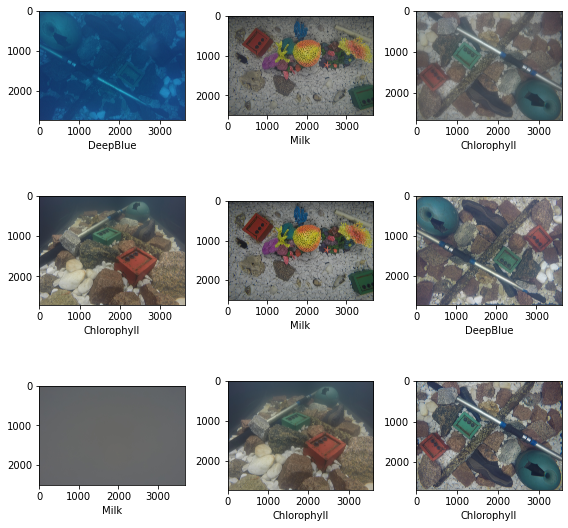

In [11]:
plot_random_image(imgFilesList, class_labels, labels)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


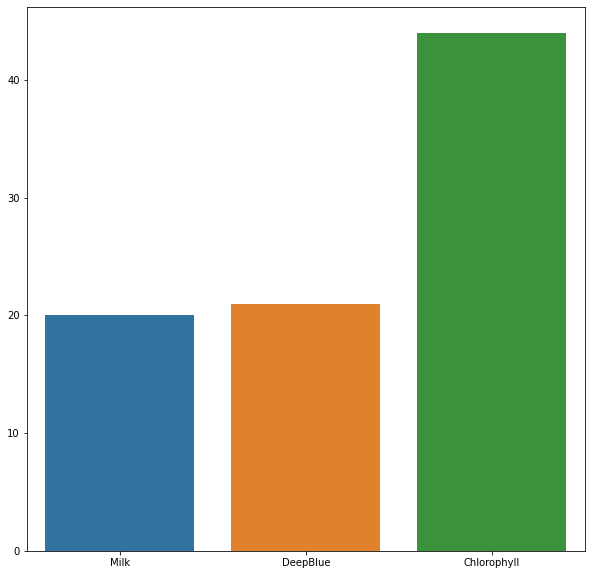

In [12]:
plt.figure(figsize=(10,10))
sns.barplot(labels, count_labels);

In [13]:
# Transforming and data partition.
# Min-max-scale 
toTensor = tv.transforms.ToTensor()
resize = tv.transforms.Resize((224,224))

def scale_image(x):
    x = resize(x)
    y = toTensor(x)
    if (y.min() < y.max()):
        y = (y-y.min())/(y.max()-y.min())
    z = y - y.mean()
    return z

def transform_(imgFilesList, class_labels):
    img_rescaled = torch.stack([scale_image(Image.open(x)) for x in imgFilesList])
    labels_rescaled = torch.tensor(class_labels)

    print(f'Min pixel value = {img_rescaled.min().item()}; Max = {img_rescaled.min().item()}; Mean = {img_rescaled.mean().item()}')

    return img_rescaled, labels_rescaled

In [14]:
img_rescaled, labels_rescaled = transform_(imgFilesList, class_labels)


Min pixel value = -0.6831187605857849; Max = -0.6831187605857849; Mean = -1.6171247674279243e-09


In [15]:

# validation and test set

def num_split_points(total_imgs, fraction = 0.1):
    validList, testList, trainList = [],[],[]

    for data in range(total_imgs):
        # shuffle the dataset
        rn = np.random.random()
        if rn < fraction:
            validList.append(data)
        elif rn < 2*fraction:
            testList.append(data)
        else:
            trainList.append(data)
    return trainList, validList, testList
    

def count_data_items(trainList, validList, testList):
    # length of the split dataset
    ntrain, nvalid, ntest = len(trainList), len(validList), len(testList)
        # output the data shape
    print('Training images = ', ntrain, "Validation = ", nvalid, "Testing = ", ntest)
    return ntrain, nvalid, ntest

def split_data(img_rescaled, labels_rescaled,ntrain, nvalid, ntest):
    
    # id corresponding to the dataset
    trainid, testid, validid = torch.tensor(trainList),\
        torch.tensor(testList), torch.tensor(validList)

    # set of training and test set.
    xtrain = img_rescaled[trainid, :, :, :]
    xtest = img_rescaled[testid, :, :, :]
    xvalid = img_rescaled[validid, :, :, :]
    ytrain = labels_rescaled[trainid]
    ytest = labels_rescaled[testid]
    yvalid = labels_rescaled[validid]


    return xtrain, xtest, xvalid, ytrain, ytest, yvalid

In [16]:
trainList, validList, testList = num_split_points(total_imgs)

ntrain, nvalid, ntest = count_data_items(trainList, validList, testList)

xtrain, xtest, xvalid, ytrain, ytest, yvalid = split_data(img_rescaled, labels_rescaled, ntrain, nvalid, ntest)

Training images =  71 Validation =  8 Testing =  6


# Model Building

In [17]:
import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo


################################################################################
# Help functions for model architecture
################################################################################

# GlobalParams and BlockArgs: Two namedtuples
# Swish and MemoryEfficientSwish: Two implementations of the method
# round_filters and round_repeats:
#     Functions to calculate params for scaling model width and depth ! ! !
# get_width_and_height_from_size and calculate_output_image_size
# drop_connect: A structural design
# get_same_padding_conv2d:
#     Conv2dDynamicSamePadding
#     Conv2dStaticSamePadding
# get_same_padding_maxPool2d:
#     MaxPool2dDynamicSamePadding
#     MaxPool2dStaticSamePadding
#     It's an additional function, not used in EfficientNet,
#     but can be used in other model (such as EfficientDet).

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'width_coefficient', 'depth_coefficient', 'image_size', 'dropout_rate',
    'num_classes', 'batch_norm_momentum', 'batch_norm_epsilon',
    'drop_connect_rate', 'depth_divisor', 'min_depth', 'include_top'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'num_repeat', 'kernel_size', 'stride', 'expand_ratio',
    'input_filters', 'output_filters', 'se_ratio', 'id_skip'])

# Set GlobalParams and BlockArgs's defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

# Swish activation function
if hasattr(nn, 'SiLU'):
    Swish = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)


# A memory-efficient implementation of Swish function
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)


def round_filters(filters, global_params):
    """Calculate and round number of filters based on width multiplier.
       Use width_coefficient, depth_divisor and min_depth of global_params.
    Args:
        filters (int): Filters number to be calculated.
        global_params (namedtuple): Global params of the model.
    Returns:
        new_filters: New filters number after calculating.
    """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    # TODO: modify the params names.
    #       maybe the names (width_divisor,min_width)
    #       are more suitable than (depth_divisor,min_depth).
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor  # pay attention to this line when using min_depth
    # follow the formula transferred from official TensorFlow implementation
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Calculate module's repeat number of a block based on depth multiplier.
       Use depth_coefficient of global_params.
    Args:
        repeats (int): num_repeat to be calculated.
        global_params (namedtuple): Global params of the model.
    Returns:
        new repeat: New repeat number after calculating.
    """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    # follow the formula transferred from official TensorFlow implementation
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """Drop connect.
    Args:
        input (tensor: BCWH): Input of this structure.
        p (float: 0.0~1.0): Probability of drop connection.
        training (bool): The running mode.
    Returns:
        output: Output after drop connection.
    """
    assert 0 <= p <= 1, 'p must be in range of [0,1]'

    if not training:
        return inputs

    batch_size = inputs.shape[0]
    keep_prob = 1 - p

    # generate binary_tensor mask according to probability (p for 0, 1-p for 1)
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    output = inputs / keep_prob * binary_tensor
    return output


def get_width_and_height_from_size(x):
    """Obtain height and width from x.
    Args:
        x (int, tuple or list): Data size.
    Returns:
        size: A tuple or list (H,W).
    """
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x
    else:
        raise TypeError()


def calculate_output_image_size(input_image_size, stride):
    """Calculates the output image size when using Conv2dSamePadding with a stride.
       Necessary for static padding. Thanks to mannatsingh for pointing this out.
    Args:
        input_image_size (int, tuple or list): Size of input image.
        stride (int, tuple or list): Conv2d operation's stride.
    Returns:
        output_image_size: A list [H,W].
    """
    if input_image_size is None:
        return None
    image_height, image_width = get_width_and_height_from_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height = int(math.ceil(image_height / stride))
    image_width = int(math.ceil(image_width / stride))
    return [image_height, image_width]


# Note:
# The following 'SamePadding' functions make output size equal ceil(input size/stride).
# Only when stride equals 1, can the output size be the same as input size.
# Don't be confused by their function names ! ! !

def get_same_padding_conv2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.
    Args:
        image_size (int or tuple): Size of the image.
    Returns:
        Conv2dDynamicSamePadding or Conv2dStaticSamePadding.
    """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """2D Convolutions like TensorFlow, for a dynamic image size.
       The padding is operated in forward function by calculating dynamically.
    """

    # Tips for 'SAME' mode padding.
    #     Given the following:
    #         i: width or height
    #         s: stride
    #         k: kernel size
    #         d: dilation
    #         p: padding
    #     Output after Conv2d:
    #         o = floor((i+p-((k-1)*d+1))/s+1)
    # If o equals i, i = floor((i+p-((k-1)*d+1))/s+1),
    # => p = (i-1)*s+((k-1)*d+1)-i

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)  # change the output size according to stride ! ! !
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """2D Convolutions like TensorFlow's 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    # With the same calculation as Conv2dDynamicSamePadding

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


def get_same_padding_maxPool2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.
    Args:
        image_size (int or tuple): Size of the image.
    Returns:
        MaxPool2dDynamicSamePadding or MaxPool2dStaticSamePadding.
    """
    if image_size is None:
        return MaxPool2dDynamicSamePadding
    else:
        return partial(MaxPool2dStaticSamePadding, image_size=image_size)


class MaxPool2dDynamicSamePadding(nn.MaxPool2d):
    """2D MaxPooling like TensorFlow's 'SAME' mode, with a dynamic image size.
       The padding is operated in forward function by calculating dynamically.
    """

    def __init__(self, kernel_size, stride, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__(kernel_size, stride, padding, dilation, return_indices, ceil_mode)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                            self.dilation, self.ceil_mode, self.return_indices)


class MaxPool2dStaticSamePadding(nn.MaxPool2d):
    """2D MaxPooling like TensorFlow's 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    def __init__(self, kernel_size, stride, image_size=None, **kwargs):
        super().__init__(kernel_size, stride, **kwargs)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                         self.dilation, self.ceil_mode, self.return_indices)
        return x


################################################################################
# Helper functions for loading model params
################################################################################

# BlockDecoder: A Class for encoding and decoding BlockArgs
# efficientnet_params: A function to query compound coefficient
# get_model_params and efficientnet:
#     Functions to get BlockArgs and GlobalParams for efficientnet
# url_map and url_map_advprop: Dicts of url_map for pretrained weights
# load_pretrained_weights: A function to load pretrained weights

class BlockDecoder(object):
    """Block Decoder for readability,
       straight from the official TensorFlow repository.
    """

    @staticmethod
    def _decode_block_string(block_string):
        """Get a block through a string notation of arguments.
        Args:
            block_string (str): A string notation of arguments.
                                Examples: 'r1_k3_s11_e1_i32_o16_se0.25_noskip'.
        Returns:
            BlockArgs: The namedtuple defined at the top of this file.
        """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            num_repeat=int(options['r']),
            kernel_size=int(options['k']),
            stride=[int(options['s'][0])],
            expand_ratio=int(options['e']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            se_ratio=float(options['se']) if 'se' in options else None,
            id_skip=('noskip' not in block_string))

    @staticmethod
    def _encode_block_string(block):
        """Encode a block to a string.
        Args:
            block (namedtuple): A BlockArgs type argument.
        Returns:
            block_string: A String form of BlockArgs.
        """
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """Decode a list of string notations to specify blocks inside the network.
        Args:
            string_list (list[str]): A list of strings, each string is a notation of block.
        Returns:
            blocks_args: A list of BlockArgs namedtuples of block args.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """Encode a list of BlockArgs to a list of strings.
        Args:
            blocks_args (list[namedtuples]): A list of BlockArgs namedtuples of block args.
        Returns:
            block_strings: A list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet_params(model_name):
    """Map EfficientNet model name to parameter coefficients.
    Args:
        model_name (str): Model name to be queried.
    Returns:
        params_dict[model_name]: A (width,depth,res,dropout) tuple.
    """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


def efficientnet(width_coefficient=None, depth_coefficient=None, image_size=None,
                 dropout_rate=0.2, drop_connect_rate=0.2, num_classes=1000, include_top=True):
    """Create BlockArgs and GlobalParams for efficientnet model.
    Args:
        width_coefficient (float)
        depth_coefficient (float)
        image_size (int)
        dropout_rate (float)
        drop_connect_rate (float)
        num_classes (int)
        Meaning as the name suggests.
    Returns:
        blocks_args, global_params.
    """

    # Blocks args for the whole model(efficientnet-b0 by default)
    # It will be modified in the construction of EfficientNet Class according to model
    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25',
        'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25',
        'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25',
        'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        image_size=image_size,
        dropout_rate=dropout_rate,

        num_classes=num_classes,
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        drop_connect_rate=drop_connect_rate,
        depth_divisor=8,
        min_depth=None,
        include_top=include_top,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """Get the block args and global params for a given model name.
    Args:
        model_name (str): Model's name.
        override_params (dict): A dict to modify global_params.
    Returns:
        blocks_args, global_params
    """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: {}'.format(model_name))
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


# train with Standard methods
# check more details in paper(EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks)
url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}

# train with Adversarial Examples(AdvProp)
# check more details in paper(Adversarial Examples Improve Image Recognition)
url_map_advprop = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',
}

# TODO: add the petrained weights url map of 'efficientnet-l2'


def load_pretrained_weights(model, model_name, weights_path=None, load_fc=True, advprop=False, verbose=True):
    """Loads pretrained weights from weights path or download using url.
    Args:
        model (Module): The whole model of efficientnet.
        model_name (str): Model name of efficientnet.
        weights_path (None or str):
            str: path to pretrained weights file on the local disk.
            None: use pretrained weights downloaded from the Internet.
        load_fc (bool): Whether to load pretrained weights for fc layer at the end of the model.
        advprop (bool): Whether to load pretrained weights
                        trained with advprop (valid when weights_path is None).
    """
    if isinstance(weights_path, str):
        state_dict = torch.load(weights_path)
    else:
        # AutoAugment or Advprop (different preprocessing)
        url_map_ = url_map_advprop if advprop else url_map
        state_dict = model_zoo.load_url(url_map_[model_name])

    if load_fc:
        ret = model.load_state_dict(state_dict, strict=False)
        assert not ret.missing_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        ret = model.load_state_dict(state_dict, strict=False)
        assert set(ret.missing_keys) == set(
            ['_fc.weight', '_fc.bias']), 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    assert not ret.unexpected_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.unexpected_keys)

    if verbose:
        print('Loaded pretrained weights for {}'.format(model_name))

In [18]:




VALID_MODELS = (
    'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3',
    'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7',
    'efficientnet-b8',

    # Support the construction of 'efficientnet-l2' without pretrained weights
    'efficientnet-l2'
)


class MBConvBlock(nn.Module):
    """Mobile Inverted Residual Bottleneck Block.
    Args:
        block_args (namedtuple): BlockArgs, defined in utils.py.
        global_params (namedtuple): GlobalParam, defined in utils.py.
        image_size (tuple or list): [image_height, image_width].
    References:
        [1] https://arxiv.org/abs/1704.04861 (MobileNet v1)
        [2] https://arxiv.org/abs/1801.04381 (MobileNet v2)
        [3] https://arxiv.org/abs/1905.02244 (MobileNet v3)
    """

    def __init__(self, block_args, global_params, image_size=None):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum  # pytorch's difference from tensorflow
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # whether to use skip connection and drop connect

        # Expansion phase (Inverted Bottleneck)
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            Conv2d = get_same_padding_conv2d(image_size=image_size)
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
            # image_size = calculate_output_image_size(image_size, 1) <-- this wouldn't modify image_size

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        image_size = calculate_output_image_size(image_size, s)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1, 1))
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Pointwise convolution phase
        final_oup = self._block_args.output_filters
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """MBConvBlock's forward function.
        Args:
            inputs (tensor): Input tensor.
            drop_connect_rate (bool): Drop connect rate (float, between 0 and 1).
        Returns:
            Output of this block after processing.
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._expand_conv(inputs)
            x = self._bn0(x)
            x = self._swish(x)

        x = self._depthwise_conv(x)
        x = self._bn1(x)
        x = self._swish(x)

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = self._swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x

        # Pointwise Convolution
        x = self._project_conv(x)
        x = self._bn2(x)

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            # The combination of skip connection and drop connect brings about stochastic depth.
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).
        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """EfficientNet model.
       Most easily loaded with the .from_name or .from_pretrained methods.
    Args:
        blocks_args (list[namedtuple]): A list of BlockArgs to construct blocks.
        global_params (namedtuple): A set of GlobalParams shared between blocks.
    References:
        [1] https://arxiv.org/abs/1905.11946 (EfficientNet)
    Example:
        >>> import torch
        >>> from efficientnet.model import EfficientNet
        >>> inputs = torch.rand(1, 3, 224, 224)
        >>> model = EfficientNet.from_pretrained('efficientnet-b0')
        >>> model.eval()
        >>> outputs = model(inputs)
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Get stem static or dynamic convolution depending on image size
        image_size = global_params.image_size
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        image_size = calculate_output_image_size(image_size, 2)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
            image_size = calculate_output_image_size(image_size, block_args.stride)
            if block_args.num_repeat > 1:  # modify block_args to keep same output size
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
                # image_size = calculate_output_image_size(image_size, block_args.stride)  # stride = 1

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        if self._global_params.include_top:
            self._dropout = nn.Dropout(self._global_params.dropout_rate)
            self._fc = nn.Linear(out_channels, self._global_params.num_classes)

        # set activation to memory efficient swish by default
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).
        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_endpoints(self, inputs):
        """Use convolution layer to extract features
        from reduction levels i in [1, 2, 3, 4, 5].
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Dictionary of last intermediate features
            with reduction levels i in [1, 2, 3, 4, 5].
            Example:
                >>> import torch
                >>> from efficientnet.model import EfficientNet
                >>> inputs = torch.rand(1, 3, 224, 224)
                >>> model = EfficientNet.from_pretrained('efficientnet-b0')
                >>> endpoints = model.extract_endpoints(inputs)
                >>> print(endpoints['reduction_1'].shape)  # torch.Size([1, 16, 112, 112])
                >>> print(endpoints['reduction_2'].shape)  # torch.Size([1, 24, 56, 56])
                >>> print(endpoints['reduction_3'].shape)  # torch.Size([1, 40, 28, 28])
                >>> print(endpoints['reduction_4'].shape)  # torch.Size([1, 112, 14, 14])
                >>> print(endpoints['reduction_5'].shape)  # torch.Size([1, 320, 7, 7])
                >>> print(endpoints['reduction_6'].shape)  # torch.Size([1, 1280, 7, 7])
        """
        endpoints = dict()

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        prev_x = x

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
            if prev_x.size(2) > x.size(2):
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = prev_x
            elif idx == len(self._blocks) - 1:
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = x
            prev_x = x

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        endpoints['reduction_{}'.format(len(endpoints) + 1)] = x

        return endpoints

    def extract_features(self, inputs):
        """use convolution layer to extract feature .
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, in_channels=3, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            in_channels (int): Input data's channel number.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'num_classes', 'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            An efficientnet model.
        """
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        model = cls(blocks_args, global_params)
        model._change_in_channels(in_channels)
        return model

    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False,
                        in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.
        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'
        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path,
                                load_fc=(num_classes == 1000), advprop=advprop)
        model._change_in_channels(in_channels)
        return model

    @classmethod
    def get_image_size(cls, model_name):
        """Get the input image size for a given efficientnet model.
        Args:
            model_name (str): Name for efficientnet.
        Returns:
            Input image size (resolution).
        """
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """Validates model name.
        Args:
            model_name (str): Name for efficientnet.
        Returns:
            bool: Is a valid name or not.
        """
        if model_name not in VALID_MODELS:
            raise ValueError('model_name should be one of: ' + ', '.join(VALID_MODELS))

    def _change_in_channels(self, in_channels):
        """Adjust model's first convolution layer to in_channels, if in_channels not equals 3.
        Args:
            in_channels (int): Input data's channel number.
        """
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size=self._global_params.image_size)
            out_channels = round_filters(32, self._global_params)
            self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)

In [19]:
model=EfficientNet.from_pretrained("efficientnet-b0", advprop=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth



Loaded pretrained weights for efficientnet-b0


In [20]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev=torch.device("cuda") 

In [21]:
model.to(dev)
#data = data.to(dev)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [22]:
from torchsummary import summary
print(summary(model, input_size=(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

# Model Training

In [23]:
def train_model(model=model,xtrain=xtrain,ytrain=ytrain,xvalid=xvalid, yvalid=yvalid):
    # learning rate
    lr = 0.01
    # Maximum training epochs
    epochs = 20
    # Maximum allowed ratio of validation to training loss
    t2vRatio = 1.2
    # Consecutive epochs before halting if validation loss exceeds above limit
    t2vEpochs = 3

    # Batch size
    batch_size = 300
    train_model.batch_size = batch_size

    # Number of training batches per epoch
    train_batch = ntrain // batch_size
    print(train_batch,'training batches')
    train_model.train_batch = train_batch

    # Validation batches
    valid_batch = nvalid // batch_size
    print(valid_batch, 'validation batches')
    train_model.valid_batch = valid_batch

    # test batch 
    test_batch = -(-ntest//batch_size)
    print(test_batch,'test batches')
    train_model.test_batch = test_batch

    # incase of any class imbalance
    CEweights = torch.zeros(nClasses)

    for i in ytrain.tolist():
        # cater for any class imbalances
        CEweights[i].add_(1)

    # Weights should be inversely related to count
    CEweights = 1. / CEweights.clamp_(min=1)
    # The weights should average to 1
    CEweights = (CEweights * nClasses/ CEweights.sum()).to(dev)

    # initialize an optimizer
    opti = om.SGD(model.parameters(), lr = lr)


    epochs_used = []
    training_accuracy = []
    train_loss = []
    valid_loss = []
    valid_accuracy = []
    test_loss = []
    test_accuracy = []

    for i in range(epochs):
        # Set model for training
        model.train()
        epochLoss = 0
        # shuffle data for random batches
        permute = torch.randperm(ntrain)

        xtrain = xtrain[permute, :, :, :]
        ytrain = ytrain[permute]

        # iterate over batches
        for j in range(train_batch):
            opti.zero_grad()

            xbatch = xtrain[j*batch_size: (j+1) * batch_size, :, :, :].to(dev)
            ybatch = ytrain[j*batch_size: (j+1) * batch_size].to(dev)
            # evaluate predictions
            y = model(xbatch)
            # compute the loss
            loss = F.cross_entropy(y, ybatch, weight=CEweights)
            #add loss
            epochLoss += loss.item()
            # back propagate
            loss.backward()
            # update model weights using optimizer
            opti.step()
            # epochLoss.append(loss.item())

        validLoss = 0
        permute = torch.randperm(nvalid)
        # go through similar proces without backpropagation and optimization
        xvalid = xvalid[permute, :, :, :]
        yvalid = yvalid[permute]

        # set model to evaluation mode
        with torch.no_grad(): # shut down gradient descent temporarily
            for j in range(valid_batch):
                opti.zero_grad()
                xbatch = xvalid[j*batch_size:(j+1)*batch_size, :, :, :].to(dev)
                ybatch = yvalid[j*batch_size:(j+1)*batch_size].to(dev)
                y = model(xbatch)
                validLoss += F.cross_entropy(y, ybatch, weight=CEweights).item()
        # average loss over batches and print it out
        epochLoss /= train_batch
        validLoss /= valid_batch

        train_loss.append(epochLoss)
        valid_loss.append(validLoss)
        epochs_used.append(i)

        print(f'Epoch = {i:-3}; Training Loss = {epochLoss:.4f}; Validation Loss = {validLoss:.4f}')

        # Test if validatio loss exceed halting threshold
        epoch_used = []
        if validLoss > t2vRatio * epochLoss:
            t2vEpochs -= 1
            if t2vEpochs < 1:
                print('Validation loss to high; halting to prevent overfitting')
                break

    return train_loss, valid_loss, epochs_used

In [24]:
torch.save(model, 'model.pth')

In [25]:
torch.save(model, 'model.h5')

In [27]:
# Convert the model.
'''import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)'''

"import tensorflow as tf\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\n\n# Save the model.\nwith open('model.tflite', 'wb') as f:\n  f.write(tflite_model)"

# Saving model

# Model Evaluation & Prediction